# Building a dark frame

A dark frame is an image taken without illuminating the sensor (in the dark). The signal in a light (as opposed to dark) image is the sum of the light signal (from the observed scene) and the dark signal. The first step when processing a light image is to subtract the *mean* dark signal.
In an individual dark frame, the values are the sum of the [bias](bias.ipynb), of the thermal signal and of the read noise. The per-pixel bias can be determined by averaging a large number of zero-second exposure dark frames. The read noise has zero mean and its standard deviation can be measured using [ptc analysis](ptc.ipynb). The thermal signal is a function of the temperature of the sensor and is proportional to the exposure time. The thermal electrons are indistinguishable from photo-electrons. For a given pixel, its value fluctuates according to Poisson statistics from frame to frame. For a given mean in a single frame, its value fluctuates from pixel to pixel.

One should not use a single dark frame to calibrate a light frame, for otherwise the random fluctuations of the thermal signal and read noise would be added to the result.
One must thus estimate the *mean* dark signal from a large number of acquisitions made at the exposure time and temperature chosen for the light images.

100%|██████████| 100/100 [00:04<00:00, 20.75it/s]


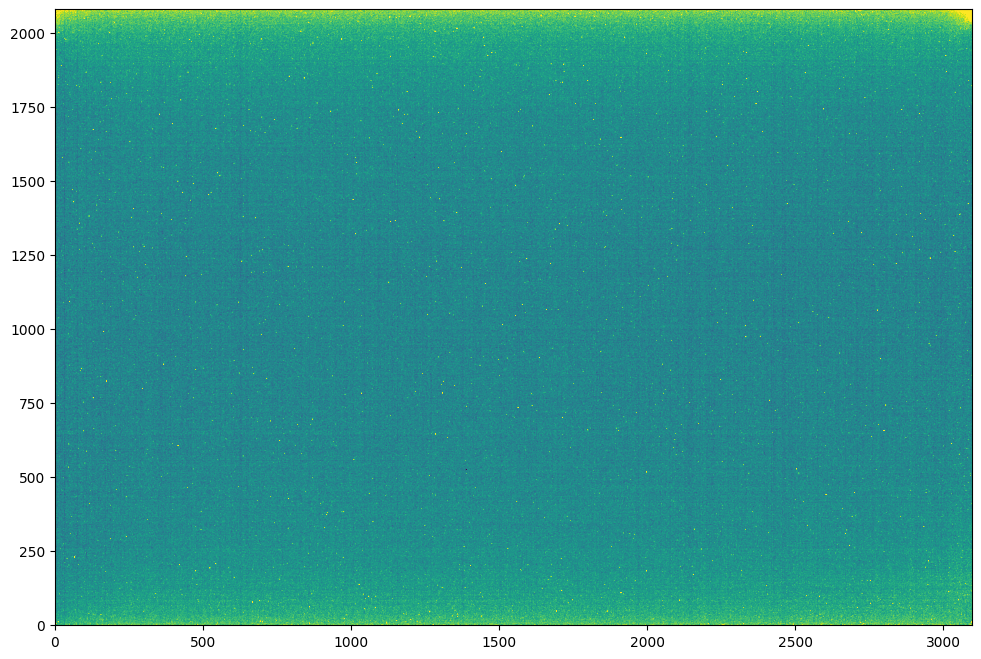

In [1]:
import os
from tqdm import tqdm
import glob
from astropy.io import fits
from astropy.visualization import ImageNormalize, LinearStretch, PercentileInterval
import matplotlib.pyplot as plt

import inout

path = r'C:\Users\fauchere\Pictures\ZWO ASI178MM-Cool\2023-07-12\DARK_2.00'

files = glob.glob(os.path.join(path, '*.fits'))

dark_frame = 0
for f in tqdm(files):
    dark_frame = dark_frame + fits.getdata(f)
dark_frame = dark_frame / len(files)

norm = ImageNormalize(dark_frame, stretch=LinearStretch(), interval=PercentileInterval(99))

fig = plt.figure(figsize=(12, 8))
plt.imshow(dark_frame, norm=norm, origin='lower')


The ASI 178 shows significant dark signal at the edges.

In [2]:
base_header = fits.getheader(files[0])

gain = base_header['GAIN']
temp = base_header['CCD-TEMP']
date = base_header['DATE-OBS']

keys = (
        ('DATE-OBS', date),
        ('INSTRUME', 'ASI178MM'),
        ('OFFSET', base_header['OFFSET']),
        ('ISO', gain),
        ('EXPTIME', base_header['EXPTIME']),
        ('NBIMGS', int(len(files))),
        ('TEMP', temp),
        ('AVGTEMP', temp)
)

inout.save_calibration_frame(rf'C:\EOS6D\bias\asi178mm_bias_iso00{gain}_t{temp:.3f}_{date[0:10]}.fits', dark_frame, keys)
